In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gc
import time
from tqdm import tqdm
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

def open_chi(path):  
    ds=(xr.open_dataset(path)*100)
    ds=ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds=ds.reindex(lon=sorted(ds.lon))  
    return ds

def update_ds(ds):  
    ds=ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds=ds.reindex(lon=sorted(ds.lon))  
    return ds
    
def ax_mesh(ds,nrows,ncols,idx,ax_title,ctext,vmin=0,vmax=100,cmap='RdYlBu_r'):
    ax = plt.subplot(nrows,ncols,idx,projection=ccrs.EqualEarth())
    p = ds.plot(vmin=vmin,vmax=vmax,
                cmap=cmap,
                ax=ax,transform=ccrs.PlateCarree(),
                add_colorbar=False,rasterized=True)
    ax.set_title(ax_title)
    ax.set_global() 
    ax.coastlines()
    cbar = plt.colorbar(p, ax=ax,
                        orientation="horizontal",
                        shrink=0.75,
                        pad=0.05,
                        extend="both")
    cbar.ax.set_xlabel(ctext)
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])
    
def modified_ax_contourf(ds,nrows,ncols,idx,ax_title,ctext,
                vmin=0,vmax=100):
    ax = plt.subplot(nrows,ncols,idx,projection=ccrs.EqualEarth())
    p = ds.plot.contourf(vmin=vmin,vmax=vmax,
                         levels=[0,0.5,1],
                         ax=ax,transform=ccrs.PlateCarree(),
                         add_colorbar=False)
    ax.set_title(ax_title)
    ax.set_global() 
    ax.coastlines()
    cbar = plt.colorbar(p, ax=ax,
                        orientation="horizontal",
                        shrink=0.75,
                        pad=0.05,
                        extend="both")
    cbar.ax.set_xlabel(ctext)
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])

In [2]:
path = "/data/keeling/a/zzheng25/d/mam4_paper_data/mam4_cesm_pred/"
save_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mask/"

## Step 1: create the mask 

In [3]:
year = "2011"
mask_raw={}
ds_ls = []
var_ls = ["bc","dst","ncl","pom","soa","so4"]
mass_ls = ["Mass_"+ var for var in var_ls]
per_ls = [var +"_per" for var in var_ls]
for i in tqdm(range(1,13)):
    month=str(i).zfill(2)
    #print("start the month:",month)
    ds = xr.open_dataset(path+str(year)+"_"+month+".nc")
    dm = ds[mass_ls].mean(dim="time")
    del ds
    gc.collect()

    dm["Mass_all"] = dm["Mass_bc"]+dm["Mass_dst"]\
                     +dm["Mass_ncl"]+dm["Mass_pom"]\
                     +dm["Mass_soa"]+dm["Mass_so4"]
    for var in var_ls:
        dm[var+"_per"]=dm["Mass_"+var]*100/dm["Mass_all"]

    ds_ls.append(dm[per_ls].assign_coords(month_idx=month).expand_dims('month_idx'))
    del dm
    gc.collect()
ds=xr.merge(ds_ls).mean(dim="month_idx")

ds["mask"] = xr.DataArray(np.ones(ds["bc_per"].shape), 
                          coords=[ds.lat, ds.lon], 
                          dims=['lat', 'lon'])

100%|██████████| 12/12 [00:24<00:00,  2.06s/it]


In [4]:
# chi_b (keep 1<bc_per<99)
mask_raw["chi_b"] = ds["mask"].where((ds["bc_per"]>1)&(ds["bc_per"]<99))\
                                    .notnull().squeeze()
# chi_c (keep 2.5<bc_per+pom_per<97.5)
mask_raw["chi_c"] = ds["mask"].where(((ds["bc_per"]+ds["pom_per"])>2.5)\
                                          &((ds["bc_per"]+ds["pom_per"])<97.5))\
                                          .notnull().squeeze()
# chi_h (keep 2.5<bc_per+dst_per+pom<97.5)
mask_raw["chi_h"] = ds["mask"].where(((ds["bc_per"]+ds["dst_per"]+ds["pom_per"])>2.5)\
                                          &((ds["bc_per"]+ds["dst_per"]+ds["pom_per"])<97.5))\
                                          .notnull().squeeze()

## Step 2: plot the mask 

/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


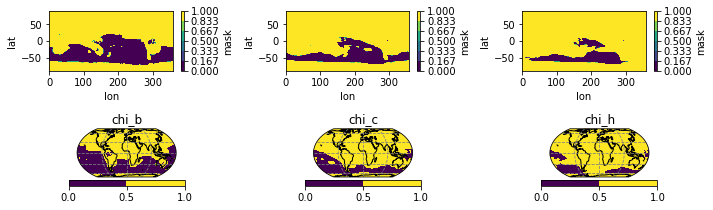

In [5]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,3))
mask_raw["chi_b"].plot.contourf(ax=ax1,vmin=0,vmax=1)
mask_raw["chi_c"].plot.contourf(ax=ax2,vmin=0,vmax=1)
mask_raw["chi_h"].plot.contourf(ax=ax3,vmin=0,vmax=1)

modified_ax_contourf(update_ds(mask_raw["chi_b"]),2,3,4,"chi_b","",
                     vmin=0,vmax=1)
modified_ax_contourf(update_ds(mask_raw["chi_c"]),2,3,5,"chi_c","",
                     vmin=0,vmax=1)
modified_ax_contourf(update_ds(mask_raw["chi_h"]),2,3,6,"chi_h","",
                     vmin=0,vmax=1)
plt.tight_layout()
plt.show()

## Step 3: apply the mask and plot

100%|██████████| 3/3 [00:47<00:00, 15.84s/it]
/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  # This is added back by InteractiveShellApp.init_path()


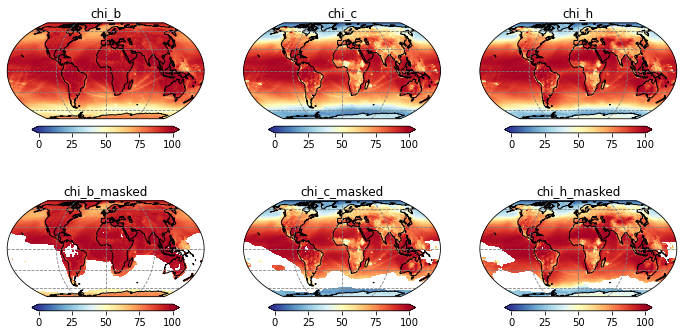

In [6]:
year = "2011"
path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_chi/"
chi_ls = ["chi_b","chi_c","chi_h"]
fig = plt.figure(figsize=(12,6))
i=1
for chi in tqdm(chi_ls):
    ds=(xr.open_dataset(path+str(year)+"_"+chi+"_mean.nc")[chi])*100
    ax_mesh(update_ds(ds),2,3,i,chi, "")
    ax_mesh(update_ds(ds.where(mask_raw[chi])),2,3,i+3,chi+"_masked", "")
    i+=1
plt.tight_layout()

## Step 4: save the mask

In [7]:
for chi in tqdm(chi_ls):
    mask_raw[chi].to_netcdf(save_path+str(year)+"_"+chi+".nc")

100%|██████████| 3/3 [00:00<00:00, 131.27it/s]
